# Recognising multiple bird species

## Library imports and helper functions

Before we get going let's import all the library components required for the task ahead, and make any settings that will facilitate the process (see comments inline):

In [1]:
# To ensure reproducibility of results, I have used  advice from the following keras documentation:
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import numpy as np
import random as python_random
from tensorflow import random
np.random.seed(0)
python_random.seed(0)
random.set_seed(0)

import os
import datetime
import pandas as pd
from matplotlib.image import imread
from matplotlib import pyplot as plt
import seaborn as sns
import random
import helper_functions # quick function for visualization of results

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorboard import notebook
%load_ext tensorboard

sns.set_theme(style="whitegrid")
sns.set_palette('Accent')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Init Plugin
Init Graph Optimizer
Init Kernel


# 1. Defining the problem and assembling the dataset

## 1.1 Problem definition

For this project I followed the 'universal workflow of machine learning' as described in __Deep Learning with Python__ (Chollet, 2018, pp. 111-115) to investigate using convolutional neural networks and transfer learning for the task of multi-class classification of images. As a keen bird-watcher, the Kaggle dataset [__BIRDS 475 SPECIES- IMAGE CLASSIFICATION__](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) (Piosenka, 2023) piqued my interest. For humans, many birds are easy to identify, having distinctive colours or shapes, while others - famously known as LBJ's or 'Little Brown Jobs' - can be quite tricky as they may be rather drab and without easily distinguishable features.

## 1.2 Assembling the dataset

The dataset was updated just 2 days prior to my starting this project. The version that i am working with (Version 61) contains images for 475 bird species. In this version we were told to expect '75,394 training images, 2375 test images (5 images per species) and 2375 validation images (5 images per species).' 

### Structure

A ```csv``` file is supplied with the dataset, containing metadata which we can use to help us understand the data structure. Here is a sample of what it looks like:

In [2]:
bird_summary = pd.read_csv('/Users/lisa.mitford/Downloads/birds/birds.csv')
bird_summary.sample(n=3, random_state=44)

class id                          filepaths               labels  \
77151       351         test/PAINTED BUNTING/3.jpg      PAINTED BUNTING   
6701         42             train/AVADAVAT/051.jpg             AVADAVAT   
59724       377  train/RED FACED CORMORANT/007.jpg  RED FACED CORMORANT   

      data set  
77151     test  
6701     train  
59724    train

Each species of bird has a label (e.g. __PAINTED BUNTING__) and an associated class id (__351__). 

Each main data set is in its own directory - there are 3 of them, i.e. ```train```, ```valid``` and ```test```:

In [3]:
print(f'''Main directories: {bird_summary['data set'].unique()}''')

Main directories: ['train' 'test' 'valid']


Within the these main directories, each set of ```jpg``` images for a bird is stored in a sub-directory with the same name as the label. 

### Compilation

Piosenka ([2023](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)) is rather informative about how the dataset has been compiled, including the following information which will be relevant for decisions in this project:

> - _This is a very high quality dataset where there is only one bird in each image and the bird typically takes up at least 50% of the pixels in the image._
> - _All images are 224 x 224 x 3 color images in jpg format._
> - _The training set is not balanced, having a varying number of files per species._
> - _However each species has at least 130 training image files._
> - _The test and validation images in the data set were hand selected to be the "best" images so your model will probably get the highest accuracy score using those data sets versus creating your own test and validation sets. However the latter case is more accurate in terms of model performance on unseen images._

The following issue is noteworthy:

> _One significant shortcoming in the data set is the ratio of male species images to female species images. About 80% of the images are of the male and 20% of the female. Males typical are far more diversely colored while the females of a species are typically bland. Consequently male and female images may look entirely different .Almost all test and validation images are taken from the male of the species. Consequently the classifier may not perform as well on female specie images._

As a bird-watcher, I am familiar with this issue: in practice one often waits to see the male of a pair make an appearance before being able to make an identification - so practically it skews the dataset towards how a human would go about, and likely struggle with, identification.

## 1.3 Investigating the dataset

### Confirming

Rather than relying entirely on the ```csv``` summary file I wanted to double-check what we had in the actual directories:

In [4]:
main_dataset_dir = '/Users/lisa.mitford/Downloads/birds/'
dataset_dir = '/Users/lisa.mitford/Downloads/birds/train/'
bird_names = [d for d in next(os.walk(dataset_dir))[1]]
bird_counts = [len(next(os.walk(dataset_dir + bird))[2]) for bird in bird_names]
bird_check = pd.DataFrame({'bird_names': bird_names, 'bird_counts': bird_counts})
bird_check.describe(percentiles = [])

bird_counts
count   475.000000
mean    158.724211
std      18.626060
min     130.000000
50%     156.000000
max     248.000000

From the above we can confirm that there are indeed 475 species included in the training dataset. And as promised, each bird has at least 130 or more images available to train on, with the mean at 159 samples. Below is the distribution of training samples available. There is a long tail of species that have more than 170 sample images, however the imbalance is not too severe, with the maximum number of samples at 248:

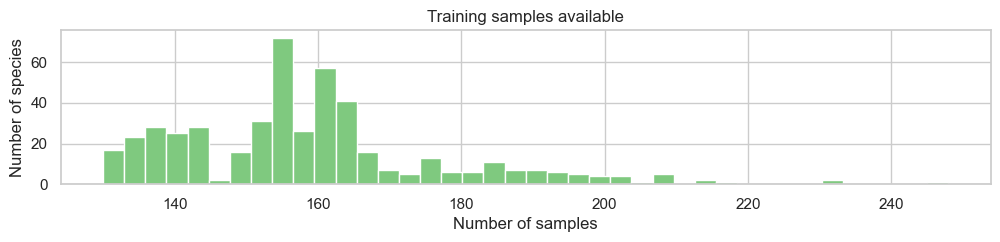

In [5]:
bird_check['bird_counts'].hist(bins = 40, figsize = (12, 2))
plt.title('Training samples available')
plt.xlabel('Number of samples')
plt.ylabel('Number of species')
plt.show()

It's also helpful to see what we actually have - below is a selection of images for a variety of species. This confirms the promise that the birds are very nicely positioned in each image, with only one bird per image:

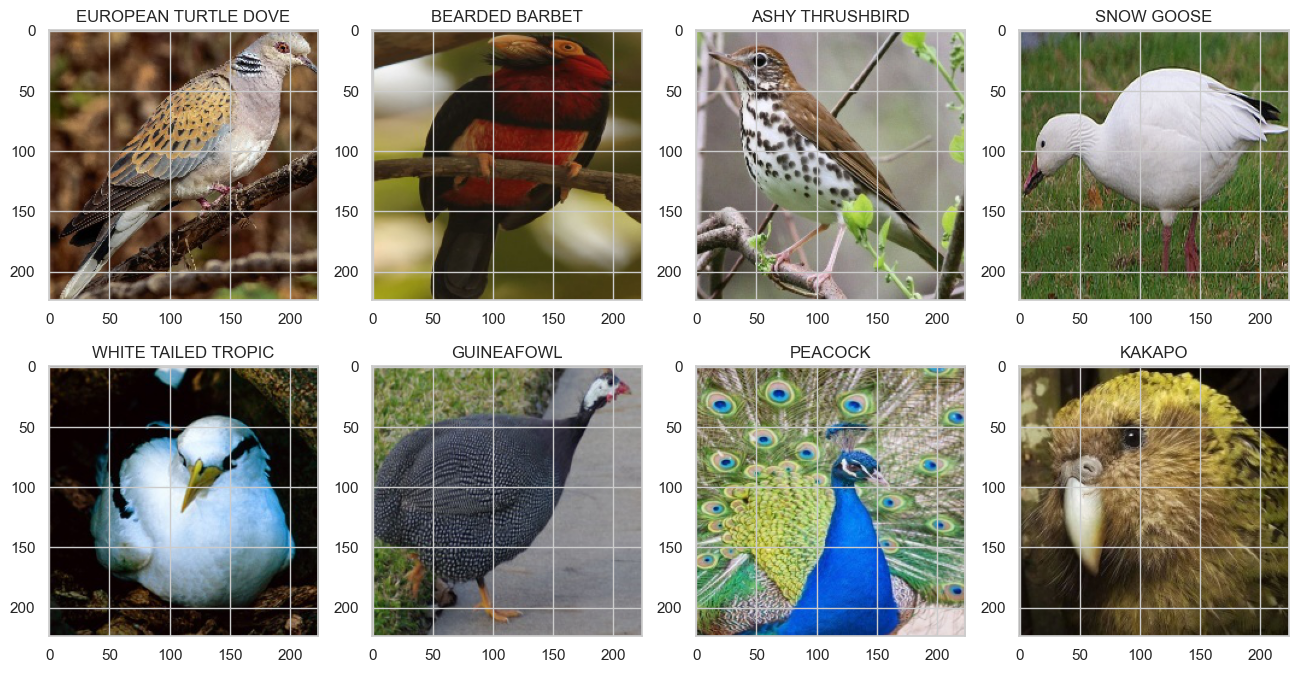

In [6]:
plt.subplots(figsize=(16,8))
sample = bird_summary.sample(8, random_state = 1)
for col in range(1,9):
    plt.subplot(2,4,col)
    image = imread('/Users/lisa.mitford/Downloads/birds/' + sample.iloc[col-1]['filepaths'])
    plt.title(sample.iloc[col-1]['labels'])
    plt.imshow(image)

# 2. Choosing a measure of success

While not every class is equally likely, given the slight imbalances in the number of samples we have per species, that imbalance is not very severe so I will use __accuracy__ as my main evaluation metric since our main interest is in the percentage of images correctly classified:

\begin{equation}
\frac{TP + TN}{TP + FP + TN + FN}
\end{equation}

# 3. Deciding on an evaluation protocol

As mentioned, our validation and test sets by default each contain 2375 validation images (5 images per species). For performance reasons, I was keen to avoid using kfold cross-validation, but at the same time I felt that the validation and test sets were a bit on the small side. In addition, we know that the validation and test sets contain the 'best' images which might lead to overly favourable results compared to real performance on unseen images of varying quality (and gender). For these reasons I have taken the decision to re-combine the given training / validation / test sets, and then do my own split. There are a total of 80144 images, which I will split as follows:

- Train (70%)
- Valid (20%)
- Test (10%)

Because of the slight imbalance in the dataset I will use __stratified sampling__ to do the split. Having done so, I will use a simple train / validation cycle to evaluate my results. And of course the test set will be reserved for testing the final model selected, based on the validation results.

Before I begin I'll just create a dataframe to keep track of key summary performance aspects as I work:

In [7]:
summary = pd.DataFrame(columns = ['model_name', 'best_val_loss', 'best_val_accuracy', 'best_epoch_loss'])

# 4. Preparing your data

## 4.1 Re-working train / validation / test split

The Keras __ImageDataGenerator__ has a handy ```flow_from_dataframe``` method ([Keras, 2023](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe)), so we can re-organize the data in a dataframe, without the need to actually move images into different directories to employ a different split. We simply need a dataframe with filepaths and labels. The ```csv``` supplied with the dataset, which we read into the ```bird_summary``` dataframe earlier, already contains this information, so we just need to perform stratified sampling on it to re-organize it into the 70 / 20 / 10 ratios we discussed above. The following re-organizes the data into 3 _non-overlapping_ splits:

In [8]:
# Create the training set by doing a stratified sample of 70% of data
train_df = bird_summary.groupby('labels', group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state = 0))
train_indices = train_df.index.to_list()

# Of the remaining 30% create the validation set by doing a stratified sample of 2/3 of the data
valid_df = bird_summary[~bird_summary.index.isin(train_indices)].groupby('labels', \
                                                     group_keys=False).apply(lambda x: x.sample(frac=0.66))
valid_indices = valid_df.index.to_list()

# Use the remaining data for the test set
test_df = bird_summary[~bird_summary.index.isin(train_indices + valid_indices)]
test_indices = test_df.index.to_list()

# Reset the df indices to avoid ordering issues later
train_df.reset_index(inplace = True, drop = True)
valid_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

# We'll also create a final training dataset that includes the entries from both train_df and valid_df
# This will be used at the end to train the final model before testing
final_train_df = pd.concat([train_df, valid_df])
final_train_df.reset_index(inplace = True, drop = True)

Let's check that the stratified sampling has been performed as expected:

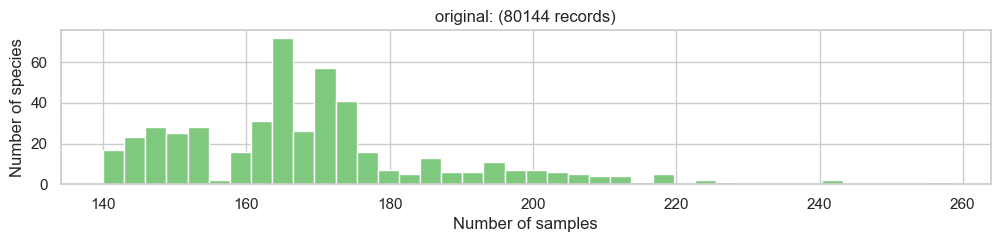

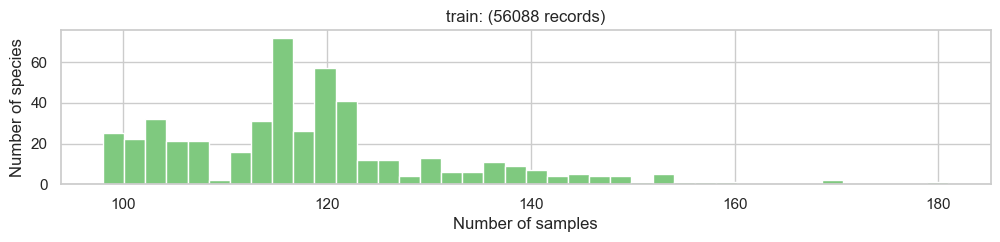

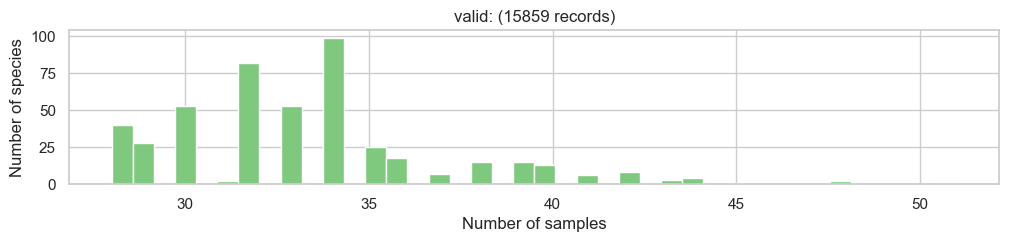

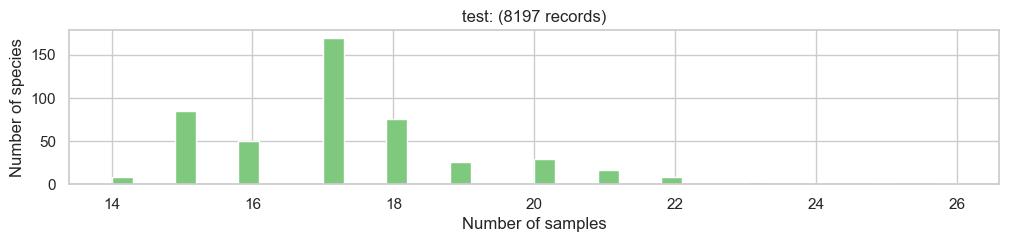

In [9]:
datasets_dict = dict(zip(['original', 'train', 'valid', 'test'], [bird_summary, train_df, valid_df, test_df]))
for key in datasets_dict.keys():
    datasets_dict[key][['labels', 'data set']].groupby('labels').count().hist(bins = 40, figsize = (12, 2))
    plt.title(f'''{key}: ({len(datasets_dict[key])} records)''')
    plt.xlabel('Number of samples')
    plt.ylabel('Number of species')
    plt.show()

This confirms that the distributions of the splits are are the same as the original dataset so we are ready to proceed.

## 4.2 Setting up image data generators

There are a few considerations when it comes to setting up data generators for computer vision:

- Using a __generator__ is essential: we would not want to attempt to load all 56088 training images into memory before training (certainly not on my laptop anyway!)
- Then as Chollet points out 'data should be formatted into appropriately preprocessed __floating-point tensors__ before being fed into the network' (2018, p.135). 
- We need to feed the data to the network in batches. A smaller __batch size__ will generally converge quicker, if slightly less accurately, so I've gone with a size of 64 here ([Brownlee, 2019](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)).
- And finally, it is very typical to make use of __data augmentation__ techniques to prevent overfitting - more on this later - but we'll start without them for the baseline models.

There are many data augmentation options, however, because our bird images are all rather nicely positioned within frame, I've elected to use just 3 simple techniques:

- ```rotation_range``` which will rotate the images randomly by up to 15 degrees in each case
- ```shear_range``` which will 'lean' the image over by up to 15 degrees in each case
- ```horizontal_flip``` which will give a mirror image of the bird

The __ImageDataGenerator__ facilitates these tasks. We will be using the __flow_from_dataframe__ method so we can use our new train / validiation / test splits prepared above. Here I create a function that will give us the required generators depending on the scenario being tested, with data augmentation or not / with transfer learning or not (because pre-trained models usually have specific pre-processing requirements):

In [10]:
def make_generators(directory, train_df, valid_df, test_df, batch_size, \
                    transfer = True, augmentation = True):
    '''Takes in a directory location, dataframes for training, validation, testing, and a batch size - and 
    returns appropriate data generators. For transfer learning (using MobileNetV2), data is prepared using 
    the supplied preprocess_input function, otherwise it is scaled by 1/255.'''
    if transfer:
        train_datagen = valid_datagen = test_datagen = \
        ImageDataGenerator(preprocessing_function=applications.mobilenet_v2.preprocess_input)
        if augmentation:
            train_datagen = ImageDataGenerator(preprocessing_function=applications.mobilenet_v2.preprocess_input,
                                               rotation_range=15,
                                               shear_range=15,
                                               horizontal_flip=True)
    else:
        train_datagen = valid_datagen = test_datagen = \
        ImageDataGenerator(rescale=1./255)
        if augmentation:
            train_datagen = ImageDataGenerator(rescale=1./255,
                                               rotation_range=15,
                                               shear_range=15,
                                               horizontal_flip=True)
    
    train_generator = train_datagen.flow_from_dataframe(
                      train_df,
                      directory=directory,
                      x_col='filepaths',
                      y_col='labels',
                      color_mode='rgb',
                      batch_size=batch_size,
                      shuffle=True,
                      seed=0,
                      class_mode='categorical',
                      validate_filenames=False)
    if isinstance(valid_df, pd.DataFrame):
        valid_generator = valid_datagen.flow_from_dataframe(
                          valid_df,
                          directory=directory,
                          x_col='filepaths',
                          y_col='labels',
                          color_mode='rgb',
                          batch_size=batch_size,
                          shuffle=True,
                          seed=0,
                          class_mode='categorical',
                          validate_filenames=False)
    else:
        valid_generator = None

    test_generator = test_datagen.flow_from_dataframe(
                     test_df,
                     directory=directory,
                     x_col='filepaths',
                     y_col='labels',
                     color_mode='rgb',
                     batch_size=batch_size,
                     shuffle = False,
                     class_mode='categorical',
                     validate_filenames=False)
    return train_generator, valid_generator, test_generator

Note: the first time I ran a model using these generators I used ```validate_filenames = True``` to be sure there were no issues, however, the documenation does state that 'disabling this option can lead to speed-up in the execution of this function' ([Keras, 2023](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe)) which is why I have selected that ```validate_filenames = False``` for subsequent runs.

Here I setup the basic generators with no transfer learning and no data augmentation:

In [11]:
train_generator, valid_generator, test_generator = \
    make_generators(directory = '/Users/lisa.mitford/Downloads/birds/', \
                    train_df = train_df, valid_df = valid_df, test_df = test_df, \
                    batch_size = 64, transfer = False, augmentation = False)

Found 56088 non-validated image filenames belonging to 475 classes.
Found 15859 non-validated image filenames belonging to 475 classes.
Found 8197 non-validated image filenames belonging to 475 classes.


# 5. Developing a model that does better than a baseline

Because there are many successful pre-trained models available (for example VGG, ResNet, Inception, MobileNet, and so on), and because training state-of-the-art models from scratch can be expensive, I would normally use transfer learning as the starting point for any computer vision task. However, for this assignment I was interested to first explore what I could achieve as a baseline by building a simple convolutional neural network from scratch.

## 5.1 Basic architecture considerations

Convolutional neural networks stack up __Conv2D__ layers and __MaxPooling2D__ layers, the outputs of which are transformed into a format appropriate for feeding into a conventional network of one or more __Dense__ layers which will deliver our final prediction. Because of their structure they efficiently condense key feature information, and are therefore faster to train than regular __Dense__ networks. The model architecture influences not only the performance of the network but also the inherent viability of the size of the network (especially given limited hardware resources). My objective with my first network was to train a basic Convnet that achieves statistical power. Remember we saw earlier that the class with the most samples has 248 images out of a total of 80144 images in the dataset, so a common sense baseline would equate to ~248/80144 or ~0.003. Our model needs to do better than that! I considered the following aspects when designing this initial basic model:

#### Convolutional layers

The __Conv2D__ layer is effectively a set of filters that are passed across each image, producing feature maps. Each feature map learns to detect a different image feature (like an edge, a colour, a texture, and so on). Below is a depiction of what is happening with only 1 colour channel. For RGB the same principles apply but the depth is 3 for the 3 colour channels.

- The ```kernel_size``` of the filter is typically either 3x3 (shown below) or 5x5.
- The number of ```filters``` determines the number of features learned. It is typical to increase the number of filters in each consecutive convolutional layer, e.g. 32, 64, 128, etc.
- The ```stride``` represents the number of pixels to move the filter at each iteration.
- The ```activation``` function gives us a non-linear output: __relu__ is very typical.

![convolution](convolution_img.png)

I opted to stack 3 __Conv2D__ layers, where the number of filters increased from 32, 64, to 128. As Chollet notes adding layers 'serves both to augment the capacity of the network and to further reduce the size of the feature maps so they aren’t overly large when you reach the __Flatten__ layer' (2018, p.133) - more on this in a moment. I chose a kernel size of (3, 3) and a stride of 1 in all but the first layer where I used a stride of 2. This latter decision was largely based on keeping the size of the network manageable.

#### Max pooling layers

The __MaxPooling2D__ layer further condenses the information: we effectively apply another (non-overlapping) filter to the feature map by simply selecting the maximum value found within each filter space: 

![maxpooling](maxpooling_img3.png)

I have used a filter of size (2, 2) for each __MaxPooling2D__ layer.

#### Global average pooling layer

As our last step we want to feed the outputs of our stacks of __Conv2D__ and __MaxPooling__ layers into a conventional densely connected classifier network. The ouputs from the convolutional part of our network are 3D tensors, however, the __Dense__ layer expects inputs as 1D vectors. Chollet uses a __Flatten__ layer which transforms the outputs of our convolutional network into a 1D format, ready for the next steps. However, I noticed that this resulted in an explosion in the number of trainable parameters so I decided to do a little further research, and came across a very illuminating article by David Landup ([2022](https://stackabuse.com/dont-use-flatten-global-pooling-for-cnns-with-tensorflow-and-keras/)) suggesting that __GlobalAveragePooling2D__ would be more effective. This is because instead of just transforming the shape, we are taking the average of each feature map from our convolutional network: '_It applies average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged. For example, a tensor (```samples, 10, 10, 32```) would be output as (```samples, 1, 1, 32```)_' ([Anon., 2021](https://androidkt.com/explain-pooling-layers-max-pooling-average-pooling-global-average-pooling-and-global-max-pooling/)). Initially, when using a __Flatten__ layer my network had 3,073,179 trainable parameters. By using a __GlobalAveragePooling2D__ layer instead I reduced the number of trainable parameters to just 154,523! 

#### Dense layer

The size of my final __Dense__ layer is determined by the number of classes: 475 classes. The ```softmax``` activation function is used for this final layer which is also our output layer. It is appropriate for multiclass classification because it will return 475 probability scores, where each score will be the probability that the current image belongs to one of our 475 bird species. These probabilities all sum to 1, and the species with the largest probability will be the predicted category.

#### <span style="color:green"><u>Experiment 1 - very basic CNN baseline</u></span>

Here is the initial model architecture as a result of the above considerations: it has a total of 154,523 trainable parameters:

In [12]:
model = models.Sequential(name = 'cnn_baseline')

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), strides = (2, 2)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.GlobalAveragePooling2D(),)
model.add(layers.Dense(475, activation='softmax'))
model.summary()

Metal device set to: Apple M1
Model: "cnn_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 111, 111, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
global_average_pooling2d

## 5.2 Compiling the model

#### Loss function

The ```categorical_crossentropy``` loss function is typically used for multi-class classification problems and will be used throughout in all my experiments.

#### Optimizer and learning rate

I've chosen to use ```Adam``` as the optimizer: it is a popular choice, known for achieving good results fast by combining the benefits of AdaGrad and RMSProp ([Brownlee, 2021](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)). For this experiment, I've left the learning rate at the default (0.001) as this iteration is all about investigating preliminary results.

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

## 5.2 Fitting the model

We're ready to fit our first model and evaluate the results. Note that when using a data generator the data is generated endlessly so __model.fit()__ needs to know how many samples to draw for training (```steps_per_epoch```) and validation (```validation_steps```).

Our training data has 56088 images, and we're using a batch size of 64. That gives us 56088/64 = 876 as our ```steps_per_epoch```. Similarly our validation data has 15859 images, which gives us 15859/64 = 248 as our ```validation_steps```.

I am limiting training to 20 epochs to get an initial feel for how the network performs.

#### ModelCheckpoint

It is useful to save the best model achieved as the epochs progress so that if, for example we find the best model was achieved after only 3 epochs of training we don't have to retrain the model to get those weights - we can simply load the weights of that best model and use it for prediction. I am therefore implementing the __ModelCheckpoint__ callback as a best practice.

#### Tensoboard

Tensorboard is a useful tool for monitoring metrics while the model is training, as well as investigating the model in more depth and comparing models. I'll be recording Tensorboard logs as I go so that I can make use of these tools later on.

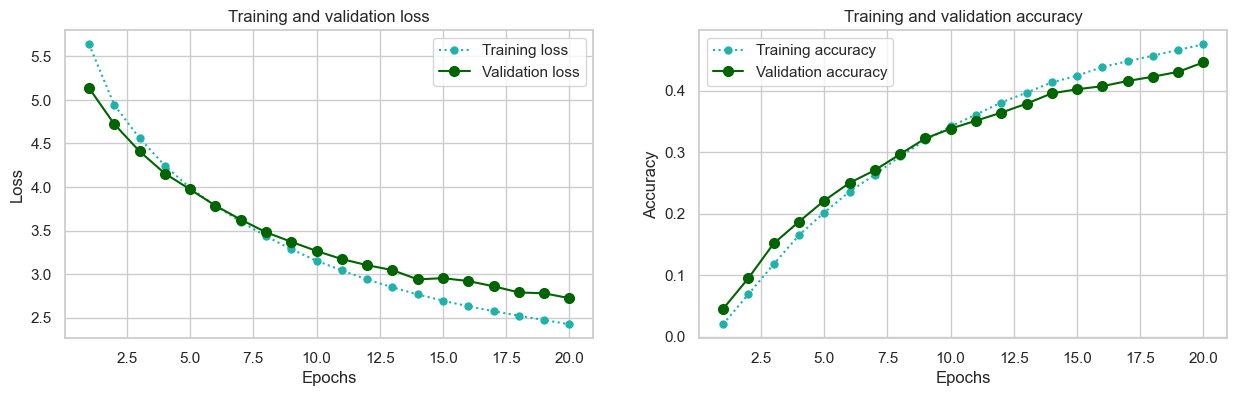

model_name best_val_loss best_val_accuracy best_epoch_loss
0  cnn_baseline        5.1361            0.4463              20

In [14]:
# Implement the ModelCheckpoint callback
filepath="exp1_cnn_baseline_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# Implement the TensorBoard callback
log_dir = "tflogs/fit/exp1_cnn_baseline/"
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard]

# Fit the model
experiment1 = model.fit(train_generator,
                        steps_per_epoch=876,
                        epochs=20,
                        validation_data=valid_generator,
                        validation_steps=248,
                        verbose = 0,
                        callbacks = callbacks_list)

# Visualize the results
helper_functions.plot_history(experiment1.history)
summary = helper_functions.populate_summary(summary, model, experiment1)
summary

With this basic model, we have certainly achieved statistical power, with ~0.45 accuracy being far superior to just guessing (remember our common sense baseline was ~0.003).

After 20 epochs validation loss is still decreasing and validation accuracy is still increasing. In addition validation and training loss, and validation and training accuracy are still tracking quite closely. We could continue to train for more epochs until we see signs of overfitting. However, at this point I am going to shift my focus to transfer learning, as this is the approach that generally makes the most sense for basic computer vision tasks such as this one: leverage a pre-trained network for faster, and often superior results.

# 6. Scaling up: developing a model that overfits

In [15]:
# Clear previous models - https://www.thekerneltrip.com/python/keras-memory-leak/
model = None 
del model
import gc
gc.collect()
from tensorflow.keras.backend import clear_session
clear_session()

Convnets trained on one set of tasks can readily be re-purposed for other tasks for 2 main reasons (Chollet, 2018, p.123): 
- many of the patterns they learn are _translation invariant_ , in other words if a pattern like a particular type of edge is learned, it can be recognised at any location in any picture
- they learn spatial hierarchies of patterns, so initial patterns learned will be _generic_ to many images

It makes sense to 'scale up' by leveraging the power of one of these pre-trained networks. There are a number of open source pre-trained models available. I have selected __MobilenetV2__ ([Keras, 2023](https://keras.io/api/applications/mobilenet/)) because it was designed to operate with minimal resources on mobile devices, and it's a relatively fast model at an estimated 3.8ms per inference step on GPU ([Keras, 2023](https://keras.io/api/applications/)).

The authors of the original paper introduce the model as 'significantly decreasing the number of operations and memory needed while retaining the same accuracy' ([Sandler, et al., 2019](https://arxiv.org/pdf/1801.04381v4.pdf)). They go on to explain 'Our main contribution is a novel layer module: the inverted residual with linear bottleneck. This module takes as an input a low-dimensional compressed representation which is first expanded to high dimension and filtered with a lightweight depthwise convolution. Features are subsequently projected back to a low-dimensional representation with a linear convolution.'

As with all pre-trained networks, there is a final section (in this case a __GlobalAveragePooling__ layer followed by a __Dense__ layer) which we can replace with our own Dense classifier which will learn the specific task of distinguishing between our 475 bird species. This approach is known as _feature extraction_.

#### <span style="color:green"><u>Experiment 2 - feature extraction</u></span>

Each pre-trained model expects input data to be in a specific format and __MobilenetV2__ is no exception. The Keras documentation advises 'For MobileNetV2, call tf.keras.applications.mobilenet_v2.preprocess_input on your inputs before passing them to the model. mobilenet_v2.preprocess_input will scale input pixels between -1 and 1.' ([Keras, 2023](https://keras.io/api/applications/mobilenet/)). Here I setup the image data generators again, but for transfer learning this time:

In [16]:
train_generator, valid_generator, test_generator = \
    make_generators(directory = '/Users/lisa.mitford/Downloads/birds/', \
                    train_df = train_df, valid_df = valid_df, test_df = test_df, \
                    batch_size = 64, transfer = True, augmentation = False)

Found 56088 non-validated image filenames belonging to 475 classes.
Found 15859 non-validated image filenames belonging to 475 classes.
Found 8197 non-validated image filenames belonging to 475 classes.


My initial architecture consists of the pretrained __MobileNetV2__ network as the base, excluding that final Dense portion of the network I mentioned (parameter ```include_top = False```). Because we do not want to re-train the __MobileNetV2__ weights we make sure that the ```trainable``` parameter is set to ```False``` so that the original weights will be preserved during the training process. 

Now I add my own Dense network on top of this base: a __GlobalAveragePooling2D__ layer (which efficiently transforms the data into a 1D tensor ready for input), followed by an intermediate __Dense__ layer with 950 neurons using __relu__ as the activation function and a final __Dense__ output layer with 475 neurons using __softmax__ as the activation function which, as explained above will return a set of 475 probabilities, one for each bird class. The original __MobileNetV2__ network only had one Dense layer, but I decided to go with two for extra capacity in light of the large number of classes my dataset has (many of which are quite similar to one another). I'll compare these results with a smaller network later.

The new model is a network with 1,668,675 trainable parameters:

In [17]:
mobilenetv2 = applications.MobileNetV2(input_shape = (224, 224, 3), include_top=False)
mobilenetv2.trainable = False

model = models.Sequential(name = 'mobilenet_baseline')

model.add(mobilenetv2)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(950, activation = 'relu'))
model.add(layers.Dense(475, activation='softmax'))
model.summary()

Model: "mobilenet_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 950)               1216950   
_________________________________________________________________
dense_1 (Dense)              (None, 475)               451725    
Total params: 3,926,659
Trainable params: 1,668,675
Non-trainable params: 2,257,984
_________________________________________________________________


In compiling the model I went with exactly the same settings as before: categorical cossentropy for the loss function and Adam for the optimizer. The default learning rate of 0.001 again made most sense as a 'first pass' to get a feel for how the network peforms. Because we are using a pre-trained network as a base I expected the performance to increase more quickly than the 'from scatch' CNN baseline model of experiment 1 so I've opted to train for an initial 15 epochs in order to assess the results:

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics=['acc'])

/Users/lisa.mitford/miniforge3/envs/dsm150_gpu/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


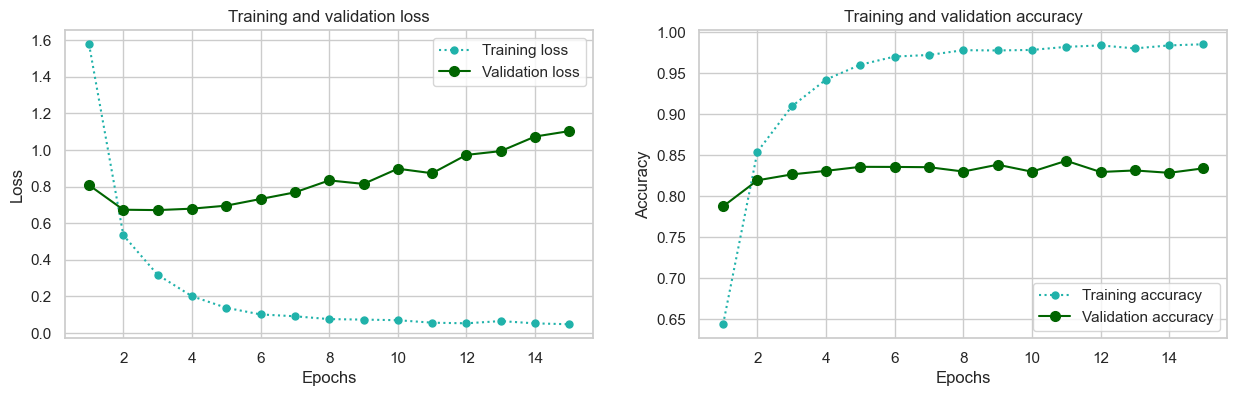

model_name best_val_loss best_val_accuracy best_epoch_loss
0        cnn_baseline        5.1361            0.4463              20
1  mobilenet_baseline        1.1032            0.8429               3

In [19]:
# Implement the ModelCheckpoint callback
filepath="exp2_mobilenet_baseline_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# Implement the TensorBoard callback
log_dir = "tflogs/fit/exp2_mobilenet_baseline/"
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard]

# Fit the model
experiment2 = model.fit(train_generator,
                    steps_per_epoch=876,
                    epochs=15,
                    validation_data=valid_generator,
                    validation_steps=248,
                    verbose = 0,
                    callbacks = callbacks_list)

# Visualize the results
helper_functions.plot_history(experiment2.history)
summary = helper_functions.populate_summary(summary, model, experiment2)
summary

The increase in accuracy to 0.84 is a immediate vindication for the transfer learning approach! We can use TensorBoard to compare the loss and accuracy metrics for experiment 1 with those of experiment 2 - there is a stark difference:

In [20]:
%tensorboard --logdir_spec exp1_cnn_baseline:tflogs/fit/exp1_cnn_baseline/,exp2_mobilenet_baseline:tflogs/fit/exp2_mobilenet_baseline/

![tensorboard1v2](tensorboard1v2.png)

However, we are seeing overfitting from epoch 4 when the validation loss starts to increase - if we can combat this, we can probably improve.

# 7. Regularizing your model and tuning your hyperparameters



To combat overfitting and promote convergence I tested incorporating 4 measures:
    
- data augmentation
- batch normalization
- dropout
- a lower learning rate

#### Fitting the model to augmented data

Chollet describes the benefits of data augmentation as follows: 'Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.' (2018, p.139)

What I found important to understand is how this really works. The term 'augmentation' almost sounds like you might be able to use it to generate _additional_ images per epoch for training. This is not the case: rather it varies the images each time they are passed to the model. Let's say we have just 100 images for training. During training we will pass 100 images to the model to train on within each epoch - but instead of passing exactly the _same_ 100 images each epoch, we'll pass variations of those images: so the images that you train on in epoch 1 will differ slightly (according to your data augmentation specifications) from the images you train on in epoch 2 and so on. In this way we avoid the model seeing exactly the same image each epoch, which helps it to generalize better.

Such augmentation measures are only performed on the training set of course: the validation and test images remain as-is. So let's setup our new training data generator:

In [21]:
# Adding rotation, shear, and horizontal flip options
train_generator, valid_generator, test_generator = \
    make_generators(directory = '/Users/lisa.mitford/Downloads/birds/', \
                    train_df = train_df, valid_df = valid_df, test_df = test_df, \
                    batch_size = 64, transfer = True, augmentation = True)

Found 56088 non-validated image filenames belonging to 475 classes.
Found 15859 non-validated image filenames belonging to 475 classes.
Found 8197 non-validated image filenames belonging to 475 classes.


And just to understand more visually what is happening let's look at a sample of what is generated:

Found 1 non-validated image filenames belonging to 1 classes.


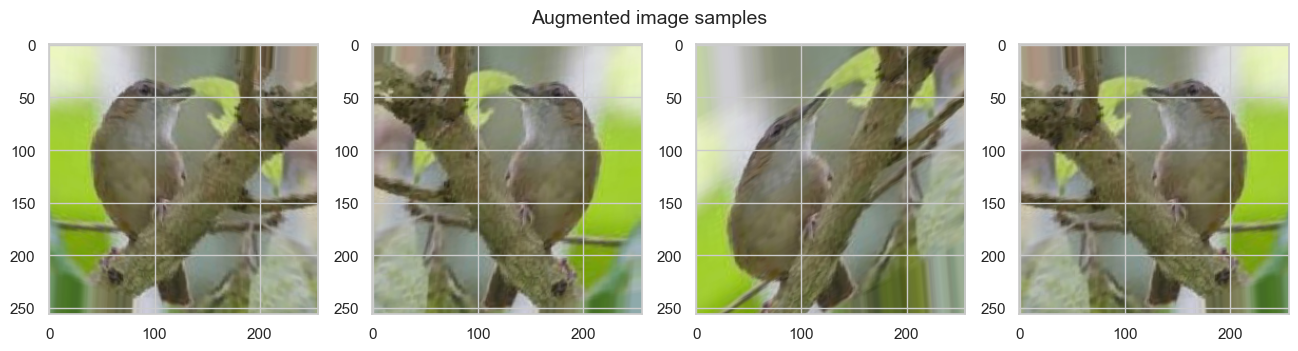

In [22]:
data_aug_sample = train_df.head(1)
sample_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=15,
                                    shear_range=15,
                                    horizontal_flip=True)
sample_generator_aug = sample_datagen.flow_from_dataframe(
                       data_aug_sample,
                       directory='/Users/lisa.mitford/Downloads/birds/',
                       x_col='filepaths',
                       y_col='labels',
                       color_mode='rgb',
                       batch_size=64,
                       shuffle=True,
                       seed=0,
                       class_mode='categorical',
                       validate_filenames=False)

plt.subplots(figsize=(16,4))
for col in range(1,5):
    plt.subplot(1,4,col)
    for x, y in sample_generator_aug:
        image = x[0]
        plt.imshow(image)
        break
    plt.imshow(image)
plt.suptitle('Augmented image samples', fontsize = 14, y = 0.92)
plt.show()

Above we see that the bird image is _slightly_ different each time: for example facing a different way, or rotated or tilted ever so slightly.

#### Batch normalization

Chollet tells us in the second edition that 'Although the original paper stated that batch normalization operates by “reducing internal covariate shift,” no one really knows for sure why batch normalization helps.' Nonetheless, he adds: 'In practice, the main effect of batch normalization appears to be that it helps with gradient propagation' (2021, p.256)

His strong recommendation is to place batch normalization _after_ a Conv2D or Dense layer, but _before_ activation and I have followed this recommendation below.

#### Dropout layer

__Dropout__ 'consists of randomly dropping out (setting to zero) a number of output features of the layer during training' and 'the dropout rate is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5' (Chollet, 2018, p. 109). I'll be adding a dropout layer of 0.4 to mitigate against overfitting.

In [23]:
# Clear previous models - https://www.thekerneltrip.com/python/keras-memory-leak/
model = None 
del model
import gc
gc.collect()
from tensorflow.keras.backend import clear_session
clear_session()

#### <span style="color:green"><u>Experiment 3 - feature extraction with overfitting measures</u></span>

Here is the architecture for my 'tamed' version of feature extraction. There are a total of 1,670,575 trainable parameters:

In [24]:
mobilenetv2 = applications.MobileNetV2(input_shape = (224, 224, 3), include_top=False, )
mobilenetv2.trainable = False

model = models.Sequential(name = 'mobilenet_tamed')

model.add(mobilenetv2)

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dropout(0.4))
model.add(layers.Dense(950))
# Batch normaliztion before activation
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Dropout(0.4))
model.add(layers.Dense(475, activation='softmax'))

model.summary()

Metal device set to: Apple M1
Model: "mobilenet_tamed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 950)               1216950   
_________________________________________________________________
batch_normalization (BatchNo (None, 950)               3800      
_________________________________________________________________
re_lu (ReLU)                 (None, 950)               0         
_________________________________________________________________
dropout_1 (Dropout)  

#### Learning rate

I am adjusting the learning rate down from the default of 0.001 to 0.0005, so that our model will take smaller, more conservative steps towards a good local minimum, or hopefully even a global minimum. In compensation for the lower learning rate I have also increased the number of epochs to 20:

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=0.0005),
              metrics=['acc'])

/Users/lisa.mitford/miniforge3/envs/dsm150_gpu/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


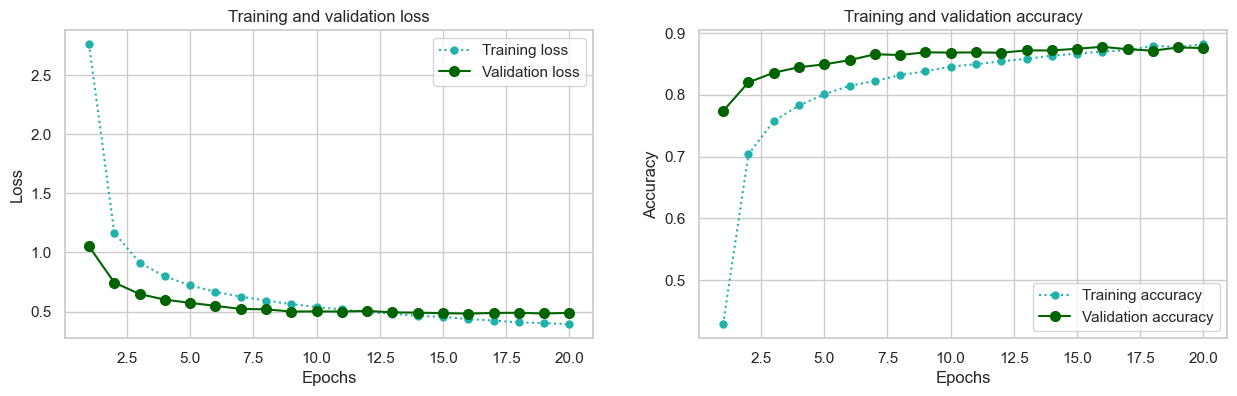

model_name best_val_loss best_val_accuracy best_epoch_loss
0        cnn_baseline        5.1361            0.4463              20
1  mobilenet_baseline        1.1032            0.8429               3
2     mobilenet_tamed        1.0506            0.8776              16

In [26]:
# Implement the ModelCheckpoint callback
filepath="exp3_mobilenet_tamed_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# Implement the TensorBoard callback
log_dir = "tflogs/fit/exp3_mobilenet_tamed/"
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard]

# Fit the model
experiment3 = model.fit(train_generator,
                    steps_per_epoch=876,
                    epochs=20,
                    validation_data=valid_generator,
                    validation_steps=248,
                    verbose = 0,
                    callbacks = callbacks_list)

# Visualize the results
helper_functions.plot_history(experiment3.history)
summary = helper_functions.populate_summary(summary, model, experiment3)
summary

This is a substantial improvement. Performance reaches its peak after sixteen epochs but we have gained an improvement of over 3 percent on our original mobilenet_baseline model! 

You may wonder at the validation accuracy being more-or-less consistently higher than the training accuracy, and similarly the validation loss being lower than the training loss: this is a common phenomenon seen when using __Dropout__ during training - the network capacity is limited at training time as a result of dropout, but the full capacity is used during validation.

This is rather a decent result, but can we do better by using a simpler architecture - as the developers of __MobilenetV2__ did?

#### <span style="color:green"><u>Experiment 4 - feature extraction with a smaller network</u></span>

The original top layer of __MobileNetV2__ consists only of a __GlobalAveragePooling2D__ layer followed by a __Dense__ layer which produces the final predictions. I was interested to compare the results of this _smaller_ Dense network architecutre with my larger architecture from experiment 3. In this iteration, I continued to make use of data augmentation which is really a 'best practice' in image recognition tasks, and I also retained the lower learning rate of 0.0005 as I wanted to guard against the model converging too fast on a potentially sub-optimal minimum. As before I settled on training for 20 epochs in order to evaluate the progress of the model.

In [27]:
# Clear previous models - https://www.thekerneltrip.com/python/keras-memory-leak/
model = None 
del model
import gc
gc.collect()
from tensorflow.keras.backend import clear_session
clear_session()

This model version has a total of 608,475 trainable parameters:

In [28]:
mobilenetv2 = applications.MobileNetV2(input_shape = (224, 224, 3), include_top=False, )
mobilenetv2.trainable = False

model = models.Sequential(name = 'mobilenet_smaller')
model.add(mobilenetv2)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(475, activation='softmax'))
model.summary()

Model: "mobilenet_smaller"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 475)               608475    
Total params: 2,866,459
Trainable params: 608,475
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=0.0005),
              metrics=['acc'])

/Users/lisa.mitford/miniforge3/envs/dsm150_gpu/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


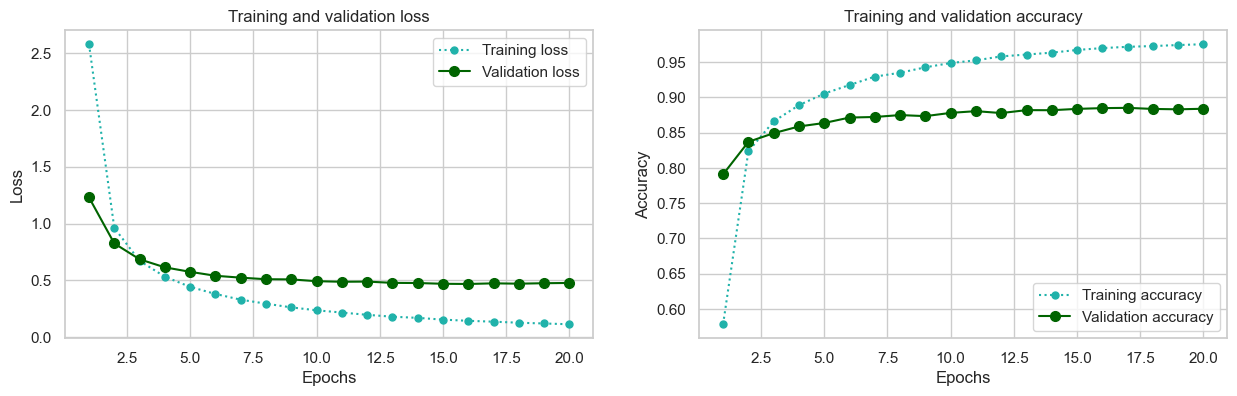

model_name best_val_loss best_val_accuracy best_epoch_loss
0        cnn_baseline        5.1361            0.4463              20
1  mobilenet_baseline        1.1032            0.8429               3
2     mobilenet_tamed        1.0506            0.8776              16
3   mobilenet_smaller        1.2298             0.885              16

In [30]:
# Implement the ModelCheckpoint callback
filepath="exp4_mobilenet_smaller_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# Implement the TensorBoard callback
log_dir = "tflogs/fit/exp4_mobilenet_smaller/"
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard]

# Fit the model
experiment4 = model.fit(train_generator,
                    steps_per_epoch=876,
                    epochs=20,
                    validation_data=valid_generator,
                    validation_steps=248,
                    verbose = 0,
                    callbacks = callbacks_list)

# Visualize the results
helper_functions.plot_history(experiment4.history)
summary = helper_functions.populate_summary(summary, model, experiment4)
summary

From the above it would appear that in fact the smaller model of experiment 4 performs slightly better than the larger 'tamed' model of experiment 3. A gain of >0.01 accuracy is significant in machine-learning terms! However, we are seeing signs of overfitting after epoch 16 where the validation loss seems to plateau. Viewed in tensorboard, we can compare the progress of the 2 models against one another:

In [33]:
%tensorboard --logdir_spec exp3_mobilenet_tamed:tflogs/fit/exp3_mobilenet_tamed/,exp4_mobilenet_smaller:tflogs/fit/exp4_mobilenet_smaller/

![tensorboard3v4](tensorboard3v4ii.png)

In both cases, the validation loss keeps decreasing during the first 16 epochs. The smaller model's accuracy is consistently higher than the 'tamed' model.

#### Fine-tuning

Now that we are seeing reasonable results from feature extraction we can go to the next level which is _fine tuning_. 'Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers.' (Chollet, 2021, p. 234). You fine tune a classifier that has _already_ been trained to your specific task - as we did in experiment 3 and 4 above - otherwise 'the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed.' He further recommends that in this process we should _not_ unfreeze any batch normalization layers. (Chollet, 2021, p.234)

Because experiment 4 achieved better results than experiment 3, I'll be using the __MobileNetV2__ base with the smaller single layer dense network on top as a basis for fine-tuning.

#### <span style="color:green"><u>Experiment 5 - finetuning</u></span>

Let's setup our network to continue training with fine-tuning.

First, I'll be loading the weights from epoch 16 of experiment 4 (which was my best epoch) and will proceed from there with fine-tuning.

There are 16 main blocks in __MobileNetV2__ and I will be fine-tuning from block 13. First we set the whole network to trainable, then refreeze the layers we do not want to train. Our final model should be trainable from block 13 onwards, excluding the batch normalization layers.

This gives us a network with a total of 2,271,835 trainable parameters:

In [31]:
# Load the weights from epoch 14
model.load_weights("exp4_mobilenet_smaller_16_0.1414.hdf5")

mobilenetv2.trainable = True
layer_names=[layer.name for layer in mobilenetv2.layers]
unfreeze_from = layer_names.index('block_13_expand')
layers_to_unfreeze = [i for i, layer in enumerate(layer_names) if not layer.lower().endswith('bn') and i >= unfreeze_from]
for i, layer in enumerate(mobilenetv2.layers):
    if i not in layers_to_unfreeze:
        layer.trainable = False
        
model.summary()

Model: "mobilenet_smaller"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 475)               608475    
Total params: 2,866,459
Trainable params: 2,271,835
Non-trainable params: 594,624
_________________________________________________________________


It is recommended to use a very low learning rate when fine tuning. Chollet explains: 'The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning.' (2021, p.236). If the learning rate was too large we would reduce the quality of the feature representations learned in the original model. Here I reduce the learning rate to 0.00001:

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=0.00001),
              metrics=['acc'])

/Users/lisa.mitford/miniforge3/envs/dsm150_gpu/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


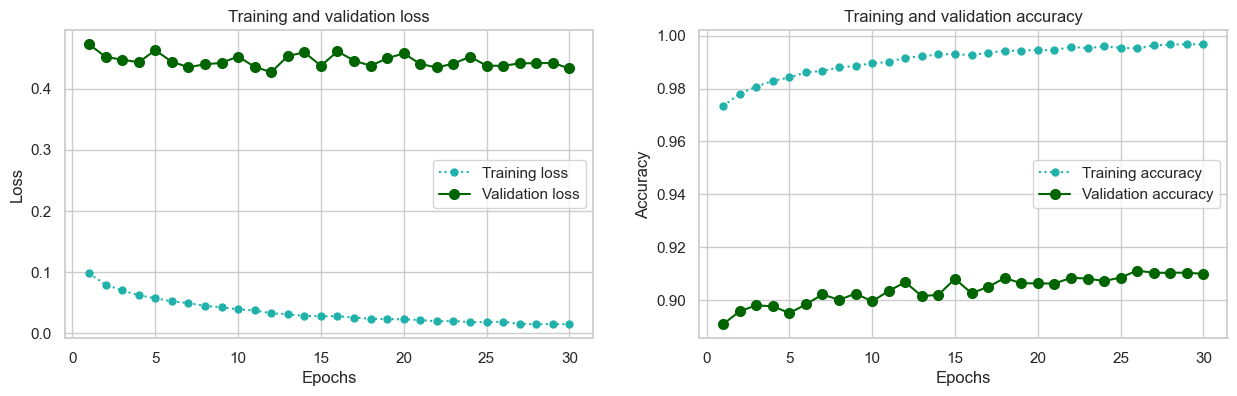

model_name best_val_loss best_val_accuracy best_epoch_loss
0        cnn_baseline        5.1361            0.4463              20
1  mobilenet_baseline        1.1032            0.8429               3
2     mobilenet_tamed        1.0506            0.8776              16
3   mobilenet_smaller        1.2298             0.885              16
4   mobilenet_smaller        0.4729            0.9112              12

In [33]:
# Implement the ModelCheckpoint callback
filepath="exp5_mobilenet_finetuned_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
log_dir = "tflogs/fit/exp5_mobilenet_finetuned/" 
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list = [checkpoint, tensorboard]

# Fit the model
experiment5 = model.fit(train_generator,
                        steps_per_epoch=876,
                        epochs=30,
                        validation_data=valid_generator,
                        validation_steps=248,
                        verbose = 0,
                        callbacks = callbacks_list)

# Visualize the results
helper_functions.plot_history(experiment5.history)
summary = helper_functions.populate_summary(summary, model, experiment5)
summary

In [34]:
summary.to_csv('summary.csv', index = False)

Fine-tuning appears to be working well: we have again increased our validation accuracy by over 3 percent. In fact based on the trends (validation loss is still going down overall, and validation accuracy is still increasing overall) it would even be worthwhile training for more epochs - there is potential there for improvement. However, in the interests of time I am now going to turn to training our final model and evaluating it on the holdout test set.

In [38]:
%tensorboard --logdir_spec exp4_mobilenet_smaller:tflogs/fit/exp4_mobilenet_smaller/,exp5_mobilenet_finetuned:tflogs/fit/exp5_mobilenet_finetuned/

![tensorboard4v5](tensorboard4v5.png)

If we compare the output from tensorboard we can see how accuracy increases and loss decreases, blwh

# 8. Train the final production model and test

I will now complete a training run on the full training set ```final_train_df```: 16 epochs of feature extraction followed by 12 epochs of finetuning which represented our best results above. We can then evaluate the results on the holdout test set ```test_df```:

In [35]:
train_generator, _, test_generator = \
    make_generators(directory = '/Users/lisa.mitford/Downloads/birds/', \
                    train_df = final_train_df, valid_df = None, test_df = test_df, \
                    batch_size = 64, transfer = True, augmentation = True)

Found 71947 non-validated image filenames belonging to 475 classes.
Found 8197 non-validated image filenames belonging to 475 classes.


In [36]:
# Clear previous models - https://www.thekerneltrip.com/python/keras-memory-leak/
model = None 
del model
import gc
gc.collect()
from tensorflow.keras.backend import clear_session
clear_session()

In [37]:
# Step 1 feature extraction
mobilenetv2 = applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False)
mobilenetv2.trainable = False
final_model = models.Sequential(name = 'final_model')
final_model.add(mobilenetv2)
final_model.add(layers.GlobalAveragePooling2D())
final_model.add(layers.Dense(475, activation='softmax'))
# Compile
final_model.compile(loss='categorical_crossentropy',
            optimizer = optimizers.Adam(learning_rate=0.0005),
            metrics=['acc'])
# Implement the ModelCheckpoint callback
filepath="final_model_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# Implement the TensorBoard callback
log_dir = "tflogs/fit/final_model/"
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard]

# Fit the model
feature_extraction_history = final_model.fit(train_generator,
                                             steps_per_epoch=1124,
                                             epochs=16,
                                             verbose = 0,
                                             callbacks = callbacks_list)

/Users/lisa.mitford/miniforge3/envs/dsm150_gpu/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [39]:
# Step 2 fine-tuning
mobilenetv2.trainable = True
layer_names=[layer.name for layer in mobilenetv2.layers]
unfreeze_from = layer_names.index('block_13_expand')
layers_to_unfreeze = [i for i, layer in enumerate(layer_names) if not layer.lower().endswith('bn') and i >= unfreeze_from]
for i, layer in enumerate(mobilenetv2.layers):
    if i not in layers_to_unfreeze:
        layer.trainable = False
        
final_model.compile(loss='categorical_crossentropy',
            optimizer = optimizers.Adam(learning_rate=0.00001),
            metrics=['acc'])

# Implement the ModelCheckpoint callback
filepath="final_model_finetuned_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# Implement the TensorBoard callback
log_dir = "tflogs/fit/final_model_finetuned/"
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard]

# Fit the model
finetuning_history = final_model.fit(train_generator,
                                     steps_per_epoch=1124,
                                     epochs=12,
                                     verbose = 0,
                                     callbacks = callbacks_list)

We can now use the ```evaluate``` function to obtain the overall loss and accuracy on our test set. Having obtained a validation accuracy of 0.9112

In [40]:
results = final_model.evaluate(test_generator)

129/129 [==============================] - 45s 341ms/step - loss: 0.3900 - acc: 0.9095


To examine the results in detail, let's get the actual predictions so we can compare them with the ground truth labels. Remember the class with the highest probability is the predicted class:

In [41]:
outputs = final_model.predict(test_generator)
test_df = test_df.assign(prediction = [np.argmax(item) for item in outputs]) 
test_df.to_csv('test_df.csv', index = False)

Now let's get the per-class accuracies so we can see where our model did well, and which classes it struggled with:

In [42]:
# https://intellipaat.com/community/17347/scikit-learn-get-accuracy-scores-for-each-class
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_df['class id'], test_df['prediction'])
confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
confusion = confusion.diagonal()

summary = test_df[['class id', 'labels']].value_counts().reset_index(name='count')
summary = summary.sort_values('class id').reset_index(drop = True)
summary = summary.assign(accuracy = confusion) 

From the accuracy summary below we can see that there are a large number of species where the accuracy is > 0.8. However, there is that long tail where the model struggled to predict correctly:

There are 294 species with >=0.9 accuracy


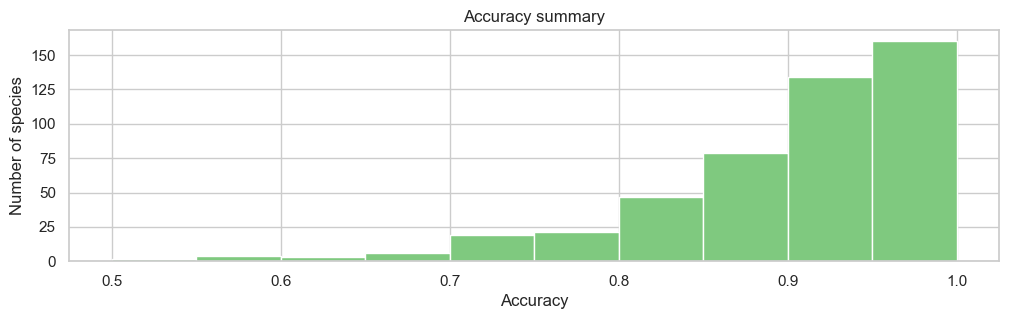

In [43]:
print(f'''There are {len(summary[summary['accuracy'] >= 0.9])} species with >=0.9 accuracy''')
summary.hist('accuracy', bins = 10, figsize =( 12, 3))
plt.title('Accuracy summary')
plt.xlabel('Accuracy')
plt.ylabel('Number of species')
plt.show()

We have a large number of classes so a confusion matrix is almost visually not feasible, however it's easy to plot the class accuracies in order so we can see which classes our model fared worst on. Let's look at the 20 worst classes:

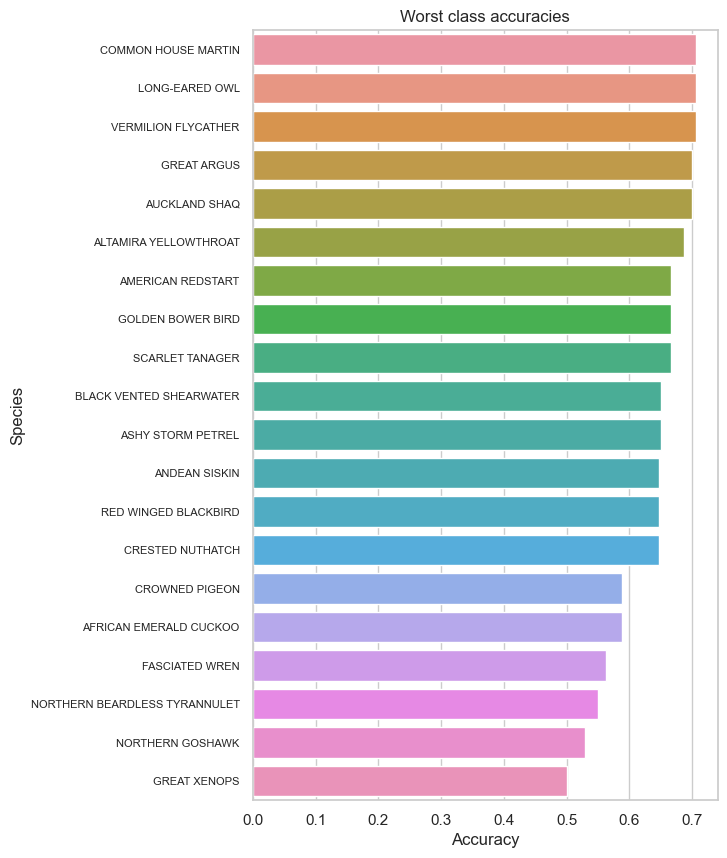

In [44]:
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(x="accuracy", y="labels", data=summary.sort_values(by = 'accuracy', ascending = False).tail(20),
            label="Per bird accuracy")
ax.yaxis.set_tick_params(labelsize = 8)
plt.title('Worst class accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Species')
plt.show()

Of all the classes the GREAT XENOPS fared the worst. We can see from the predictions that there are several birds that it got confused with:

In [46]:
test_df[test_df['labels'] == 'GREAT XENOPS']

class id                   filepaths        labels data set  prediction
3861       242  train/GREAT XENOPS/005.jpg  GREAT XENOPS    train         135
3862       242  train/GREAT XENOPS/010.jpg  GREAT XENOPS    train         242
3863       242  train/GREAT XENOPS/035.jpg  GREAT XENOPS    train         242
3864       242  train/GREAT XENOPS/039.jpg  GREAT XENOPS    train         384
3865       242  train/GREAT XENOPS/054.jpg  GREAT XENOPS    train          61
3866       242  train/GREAT XENOPS/059.jpg  GREAT XENOPS    train         135
3867       242  train/GREAT XENOPS/068.jpg  GREAT XENOPS    train         242
3868       242  train/GREAT XENOPS/071.jpg  GREAT XENOPS    train         242
3869       242  train/GREAT XENOPS/083.jpg  GREAT XENOPS    train         330
3870       242  train/GREAT XENOPS/100.jpg  GREAT XENOPS    train         135
3871       242  train/GREAT XENOPS/118.jpg  GREAT XENOPS    train         242
3872       242  train/GREAT XENOPS/134.jpg  GREAT XENOPS    train         242
3873       242  train/GREAT XENOPS/140.jpg  GREAT XENOPS    train          23
3874       242  train/GREAT XENOPS/141.jpg  GREAT XENOPS    train         209
7804       242     test/GREAT XENOPS/1.jpg  GREAT XENOPS     test         242
7805       242     test/GREAT XENOPS/4.jpg  GREAT XENOPS     test         242

Let's have a look at what the GREAT XENOPS (and some of the birds it was confused with) look like:

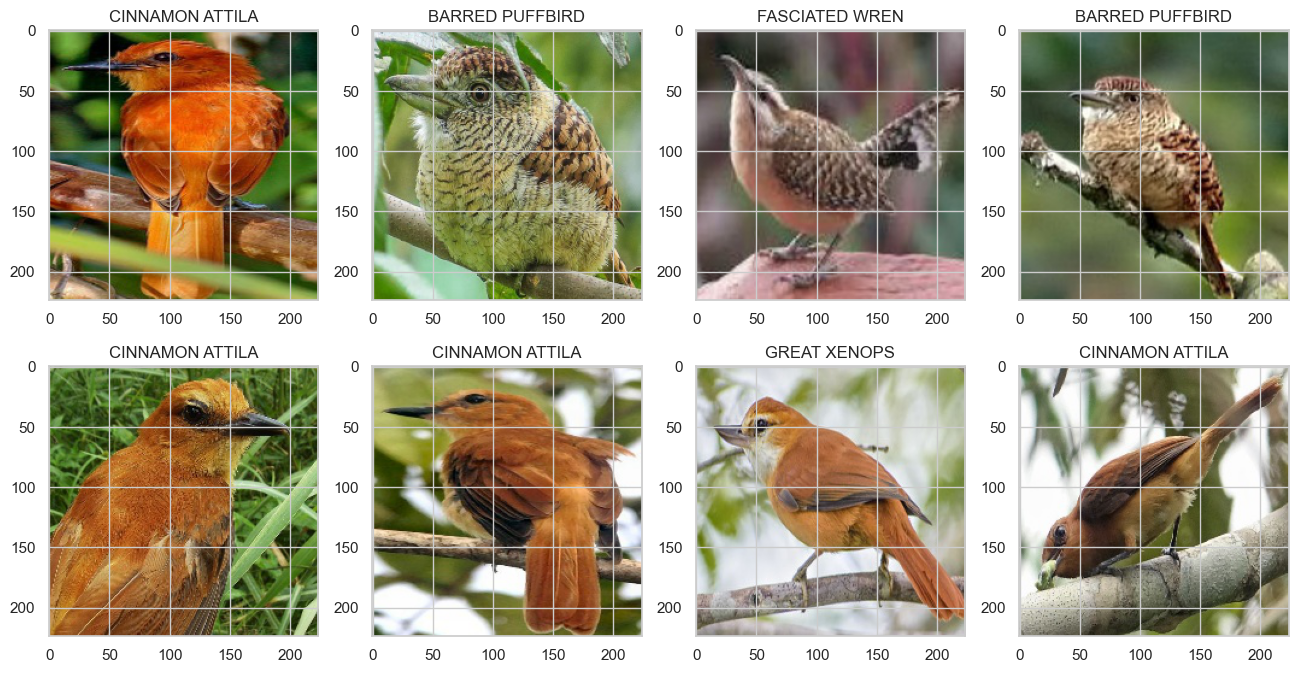

In [49]:
sample = bird_summary[bird_summary['class id'].isin(test_df.loc[test_df['labels'] == \
                                            'GREAT XENOPS', 'prediction'])].sample(8, random_state=2)
plt.subplots(figsize=(16,8))
for col in range(1,9):
    plt.subplot(2,4,col)
    image = imread('/Users/lisa.mitford/Downloads/birds/' + sample.iloc[col-1]['filepaths'])
    plt.title(sample.iloc[col-1]['labels'])
    plt.imshow(image)

The similarities in colouring and form between the GREAT XENOPS and the CINAMMON ATTILLA are quite apparent. However the BARRED PUFFBIRDs selected in the random selection above do _not_ look particularly similar. But looking at specific bird images I could find variants where that same distinctive rust colouring occurs which seems to be the possible source of confusion (see image below). It's a Panamanian bird that I am unfamiliar with, however such variations are common not only between males and females, but also between adults and juveniles. This is one of the aspects that makes bird-watching tricky for humans too.

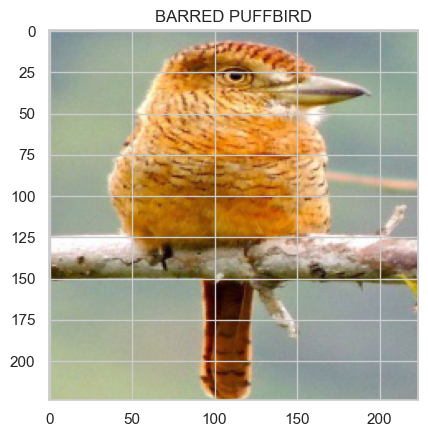

In [50]:
image = imread('/Users/lisa.mitford/Downloads/birds/' + 'train/BARRED PUFFBIRD/022.jpg')
plt.title('BARRED PUFFBIRD')
plt.imshow(image, )
plt.show()

The bird at the top of the list of 'confused birds' is the COMMON HOUSE MARTIN. This is a bird that I am familiar with and the confusion therefore did not surprise me much. Let's look at this bird and some of the species it was confused with:

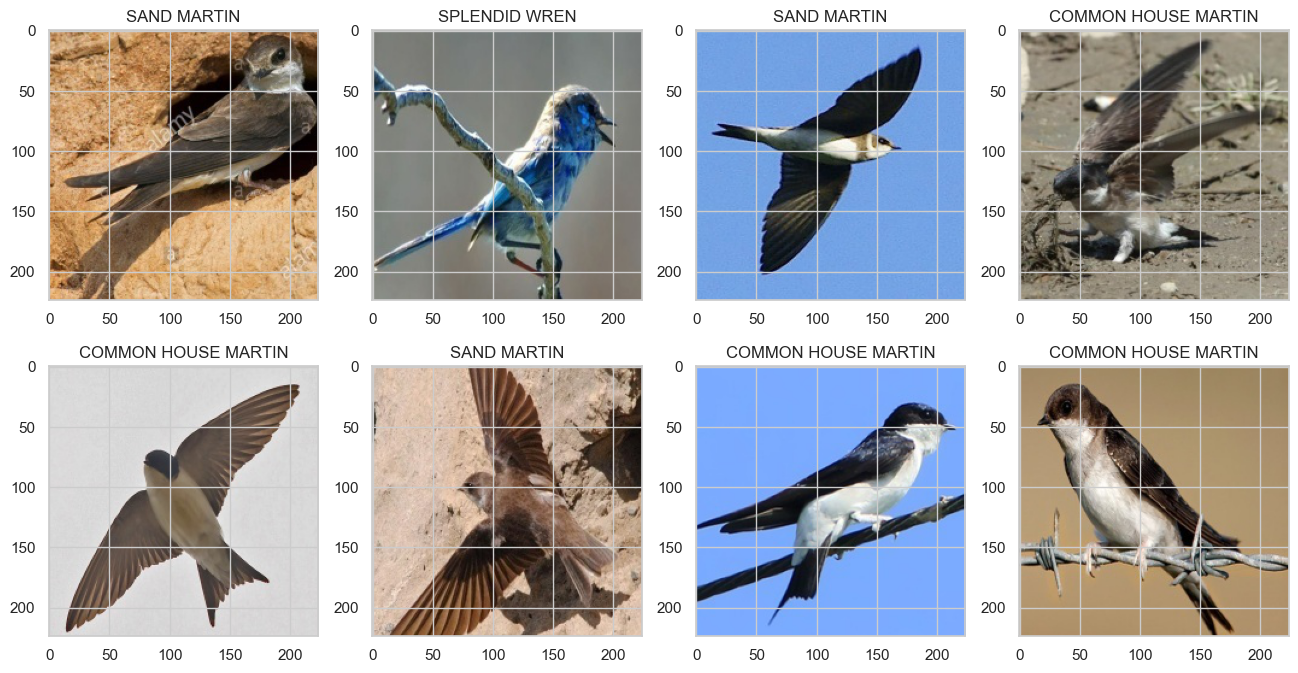

In [51]:
sample = bird_summary[bird_summary['class id'].isin(test_df.loc[test_df['labels'] == \
                                            'COMMON HOUSE MARTIN', 'prediction'])].sample(8, random_state=1)
plt.subplots(figsize=(16,8))
for col in range(1,9):
    plt.subplot(2,4,col)
    image = imread('/Users/lisa.mitford/Downloads/birds/' + sample.iloc[col-1]['filepaths'])
    plt.title(sample.iloc[col-1]['labels'])
    plt.imshow(image)

The SAND MARTIN in particular is a very similar looking bird.

In [ ]:
bird_summary[bird_summary['class id'] == 259].head(1)

By visualizing an image of each bird side-by-side I see that this is the kind of distinction that amateur human bird watchers would also struggle with!

# 9. Conclusions and next steps

A final test accuracy of 0.9095 was reasonable. If time had permitted one could keep tinkering of course! For example in experiment 5 we had not established if we had reached the boundary of the best performance we could obtain with fine-tuning, and given the low learning rate it is quite possible performance could continue to improve steadily for more epochs. I, however, had an assignment deadline so I had to call it quits at this point!

# References

Keras, 2023. _How can I obtain reproducible results using Keras during development?_. [Online] 
Available at: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
[Accessed 2023].

Chollet, F., 2018. _Deep Learning with Python_. 1st ed. Shelter Island, NY: Manning Publications Co.

Piosenka, G., 2023. _BIRDS 475 SPECIES- IMAGE CLASSIFICATION_. [Online] 
Available at: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
[Accessed 2023].

Keras, 2023. _flow_from_dataframe_. [Online] 
Available at: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
[Accessed 2023].

Brownlee, J., 2019. _A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size_. [Online] 
Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/
[Accessed 2023].

Landup, D., 2022. _Don't Use Flatten() - Global Pooling for CNNs with TensorFlow and Keras_. [Online] 
Available at: https://stackabuse.com/dont-use-flatten-global-pooling-for-cnns-with-tensorflow-and-keras/
[Accessed 2023].

Anon., 2021. _Explain Pooling layers: Max Pooling, Average Pooling, Global Average Pooling, and Global Max pooling_. [Online] 
Available at: https://androidkt.com/explain-pooling-layers-max-pooling-average-pooling-global-average-pooling-and-global-max-pooling/
[Accessed 2023].

Brownlee, J., 2021. _Gentle Introduction to the Adam Optimization Algorithm for Deep Learning_. [Online] 
Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
[Accessed 2023].

RUser4512, 2021. _Keras Memory Leak_. [Online] 
Available at: https://www.thekerneltrip.com/python/keras-memory-leak/
[Accessed 2023].

Keras, 2023. _MobileNet, MobileNetV2, and MobileNetV3_. [Online] 
Available at: https://keras.io/api/applications/mobilenet/
[Accessed 2023].

Keras, 2023. _Keras Applications_. [Online] 
Available at: https://keras.io/api/applications/
[Accessed 2023].

Sandler, M. et al., 2019. _MobileNetV2: Inverted Residuals and Linear Bottlenecks_. [Online] 
Available at: https://arxiv.org/pdf/1801.04381v4.pdf
[Accessed 2023].

Anurag, 2019. _Scikit-learn, get accuracy scores for each class_. [Online] 
Available at: https://intellipaat.com/community/17347/scikit-learn-get-accuracy-scores-for-each-class
[Accessed 2023].
